# Psuedo 2D (P2D) Battery Model Development

This document will aid in the development of a P2D battery model by providing model framework and governing equations. In general, the model will predict the voltage response for a given user input current. Specifically, this model will be used to study the effects physical parameters have on the electrochemical impedance spectroscopy (EIS) response of a battery.

The battery being modeled is a A123 18650 spiral cell that has a capacity of 1.08 Ah.
Placeholder Picture
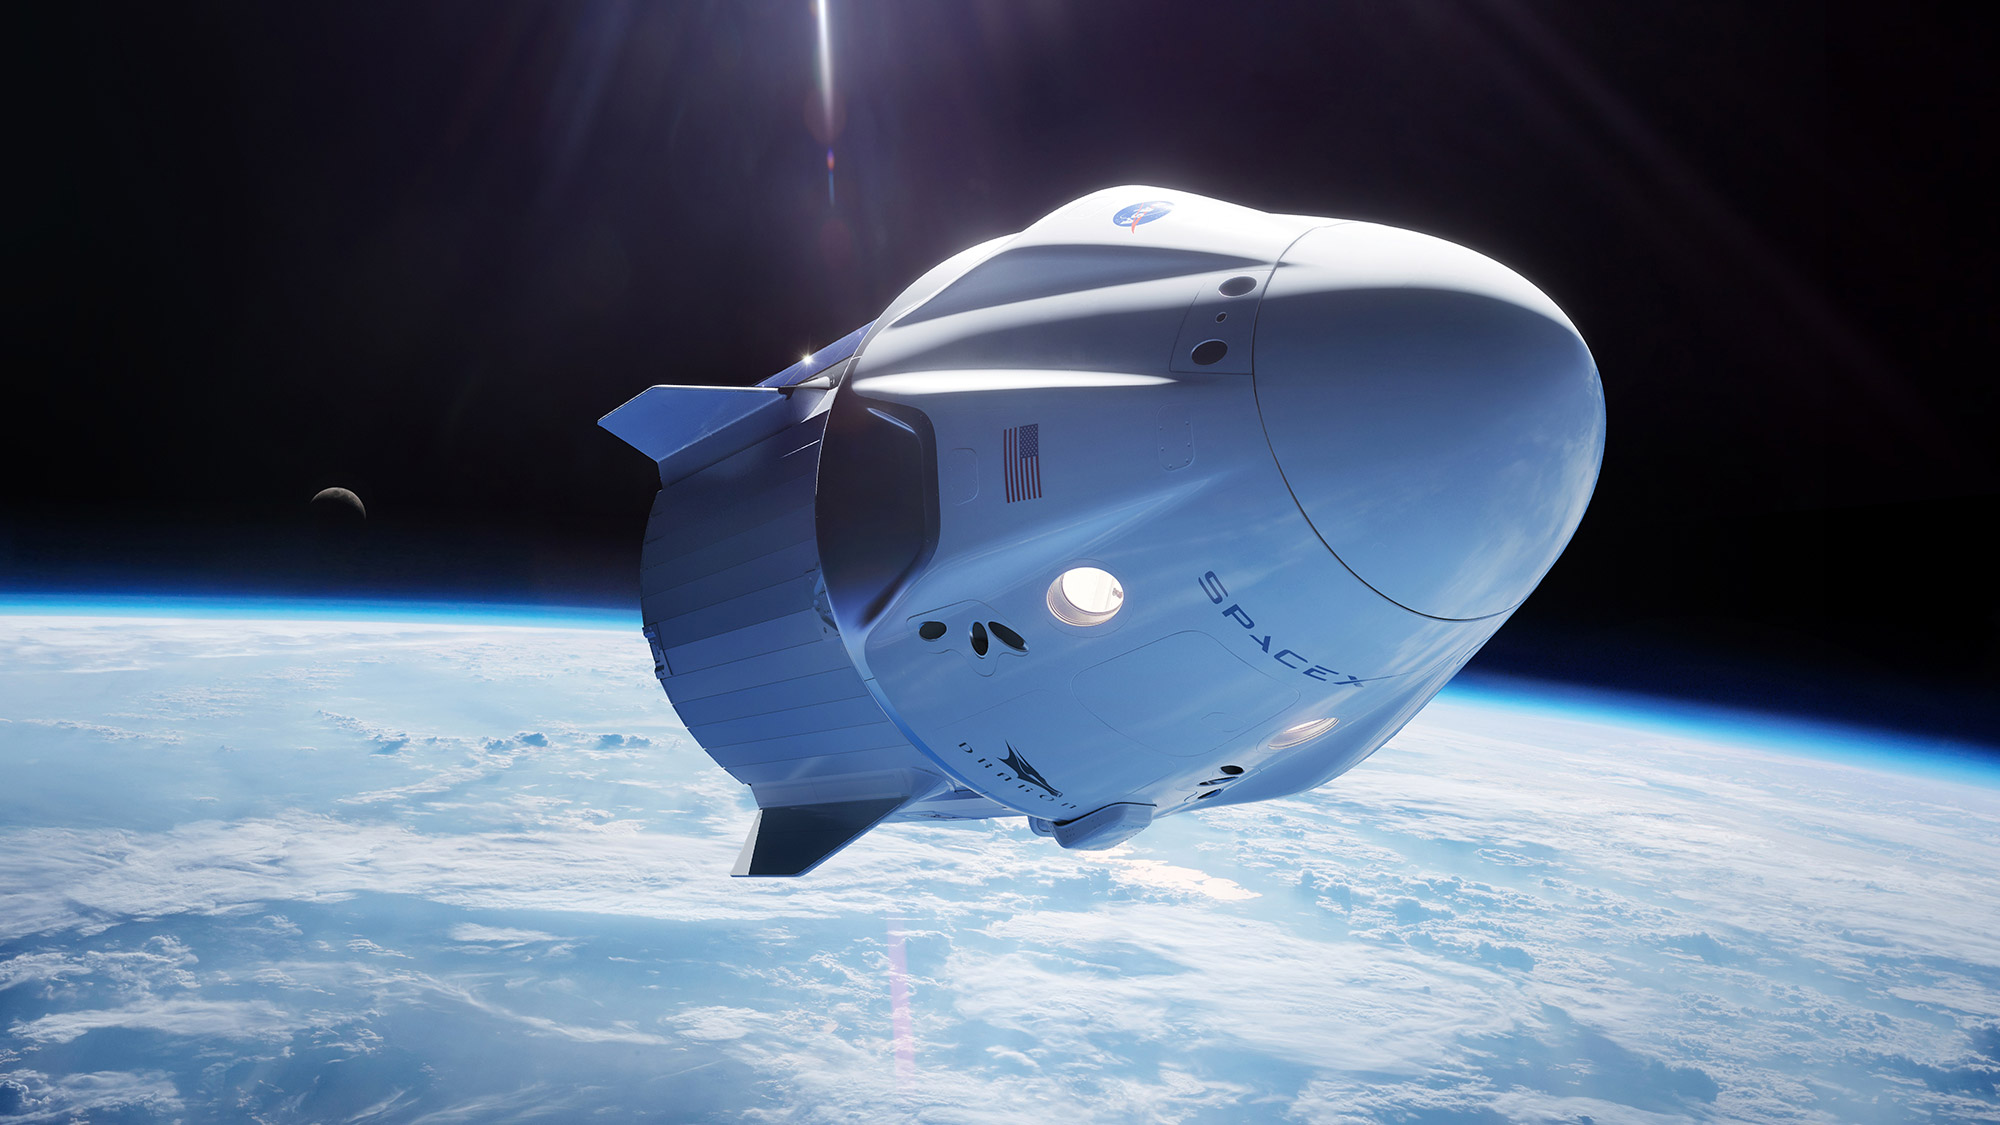

The model domain includes:
- Porous graphite anode
- Porous electrolyte separator
- Porous LiFePO$_4$ (LFP) cathode

The liquid electrolyte will consist of 1 M LiPF$_6$ in a 1:1 v/v mixture of EC and DMC.
****************(I don't know what the elyte is yet so this is a placeholder)

The simulation will assume a constant temperature of 308 K.  We will further assume that the anode, cathode, and electrolyte phases are incompressible (constant molar density).

The state variables are: (Not all of these are currently implemented)
- Li intercalation fraction $X_{\rm Li}$ in the graphite, $X_{\rm Li,an}$
- Electric potential of the graphite (Currently this will be assumed 0, and the double layer voltage of the anode will be the SV)
- Concentration of the Li+ in the electrolyte in the anode.
- Electrolyte electric potential in the anode.
- Concentration of the Li+ in the electrolyte in the separator.
- Electrolyte electric potential in the separator.
- Concentration of the Li+ in the electrolyte in the cathode.
- Electrolyte electric potential in the cathode.
- Li intercalation fraction $X_{\rm Li}$ in the LFP, $X_{\rm Li,ca}$
- Electric potential in the LFP (Currently the double layer voltage of the cathode will be the SV)

## Road Map for model development
Placeholder Picture
![FalconHeavy](JupyterNotebookPictures/Space-X-falcon-heavy-space-rocket-Quad-HD-wallpapers-2.jpg)

Development of the model will proceed as follows
- A single particle of anode material 
- Two particles; one anode, one cathode
- Single particle model (SPM) for anode, cathode, and seporator
    - Conservation of charge, HW 5
- Polarization curve using the SPM
- Add diffusion effects
- Expand to P2D

## Current Assumptions/Simplifications
- 

## Conservation of charge:

### Double layer current:

We begin with conservation of charge at the electrolyte/electrode double layers.  Calling 'el' the electrode phase:
\begin{equation}
    \frac{\partial Q_{\rm el}}{\partial t} = 0 = \pm I_{\rm ext} -i _{\rm Far}A_{\rm surf} - i_{\rm dl}A_{\rm surf}
\end{equation}

which leads eventually to:

\begin{equation}
    i_{\rm dl} = \pm i_{\rm ext}\frac{A_{\rm geo}}{A_{\rm surf}} -i _{\rm Far}
\end{equation}
where the sign on $i_{\rm ext}$ depends on whether we deal with the cathode or the anode.  We consider positive current as the discharge current, which delivers positive charge to the anode ($i_{\rm ext}$), and negative charge to the cathode ($-i_{\rm ext}$). $i_{\rm dl}$ and $i_{\rm Far}$ both move positive charge from the electrode to the electrolyte bulk interior.
where we name the geometric factor $A_{\rm fac}$:
\begin{equation}
    A_{\rm fac} = \frac{A_{\rm geo}}{A_{\rm surf}} = \frac{r_p}{3H_{\rm el}\varepsilon_{\rm AM}}
\end{equation}
where $r_p$ is the active material particle radius, $H_{\rm el}$ is the electrode thickness, and $\varepsilon_{\rm AM}$ is the active material volume fraction in the electrode.


### Double layer potential:

The charge separation at the double layer (C/m$^2$) then evolves as:

\begin{equation}
    \frac{\partial q_{\rm dl}}{\partial t} = i_{\rm dl}
\end{equation}
Defining the charge separation as $q_{\rm dl} = q_{\rm el} - q_{\rm elyte}$ and $\Delta \phi_{\rm dl} = \phi_{\rm el} - \phi_{\rm elyte}$: 

\begin{equation}
    \frac{d\Delta\phi_{\rm dl}}{dt} =\frac{d\left(\phi_{\rm el} - \phi_{\rm elyte}\right)}{dt} = \frac{i_{\rm dl}}{C_{\rm dl}} = \frac{1}{C_{\rm dl}}\left(\pm i_{\rm ext}A_{\rm fac}-i_{\rm Far}\right)
\end{equation}

## Assumptions and boundary conditions.

### In the anode:
We get to pick one electric potential as our reference condition ($\phi = 0$).  Without loss of generality, assume the anode is our reference: 

\begin{equation}
    \phi_{\rm an} = 0 {\rm V.}
\end{equation}
From this, we can calculate the electrolyte electric potential in the anode pores as:

\begin{equation}
    \phi_{\rm elyte,an} = \phi_{\rm an} - \Delta\phi_{\rm dl,an}
\end{equation}
which means that $\Delta\phi_{\rm dl}$ can serve as our state variable.

### In the cathode:
We assume, initially, that the electrolyte across the separator has a fixed resistance:

\begin{equation}
    R_{\rm sep} = \frac{1}{\sigma_{\rm io,elyte}}\left(H_{\rm sep} + 0.5\,H_{\rm an} + 0.5\,H_{\rm ca}\right)
\end{equation}
where $H$ is the component thickness and $\sigma_{\rm io,elyte}$ is the effective ionic conductivity of the electrolyte (incorporating any microstructure effects).

From this, we can calculate the elecric potential of the electrolyte in the cathode, relative to that in the anode:

\begin{equation}
    \phi_{\rm elyte,ca} = \phi_{\rm elyte,an} - i_{\rm ext}R_{\rm sep}
\end{equation}
Finally, we can calculate the cathode active material electric potential, relative to the known electrolyte electric potential and the double layer potential:

\begin{equation}
    \phi_{\rm ca} = \phi_{\rm elyte,ca} + \Delta\phi_{\rm dl,ca}
\end{equation}

Therefore, it is sufficient to store the two double layer potntials $\Delta\phi_{\rm dl,an}$ and $\Delta\phi_{\rm dl,ca}$, which along with $R_{\rm sep}$ and $i_{\rm ext}$ can determine all electric potentials at a given time.

In [77]:
# Inputs:

C_rate = 0.1 # How many charges per hour?

T = 298 #K

r_p_an = 4e-6 #m
phi_an_0 = 0 #V
C_dl_an = 1e4 #F/m2
i_o_an = 4.0  #A/m2
n_an = -1
beta_an = 0.5
H_an = 30e-6  #m
density_graphite = 2260 #kg/m3
capacity_graphite = 350 #Ah/kg
eps_graphite = .65
dPhi_eq_an = -1.6

phi_sep_0 = 1.8  #V

r_p_ca = 0.3e-6 #m
phi_ca_0 = 4.6  #V
C_dl_ca = 1e4 #F/m2
i_o_ca = 100 #A/m2
n_ca = -1
beta_ca = 0.5
H_ca = 50e-6  #m
density_LCO = 2292  #kg/m3
capacity_LCO = 175  #Ah/kg
eps_LCO = 0.65
dPhi_eq_ca = 2.6

# How deep do we want to charge/discharge?
charge_frac = 0.9

### Capacity
We need to calculate the total charge we can store in each electrode (the capacity). This is typically calculated in A-h (1 A-h = 3600 Coulombs). Each active material has a known gravimetric capacity, which can be converted to the electrode capacity (per m$^2$ of battery):

\begin{equation}
    {\rm Cap} = C_{\rm AM}\rho_{\rm AM}\varepsilon_{\rm AM}H_{\rm el}
\end{equation}

The total battery capacity is the minimum of the two electrode capacities.  For a given C-rate, then, the external current density equals the C-rate multiplied by the capacity.

In [78]:
# Initialize:
phi_dl_an_0 = phi_an_0 - phi_sep_0
phi_dl_ca_0 = phi_ca_0 - phi_sep_0


capacity_anode = capacity_graphite*H_an*eps_graphite*density_graphite
capacity_cathode = capacity_LCO*H_ca*eps_LCO*density_LCO
capacity_area = min(capacity_anode,capacity_cathode)


t_final = charge_frac*3600./C_rate
i_ext = C_rate*capacity_area

A_fac_an = r_p_an/3/H_an/eps_graphite
A_fac_ca = r_p_ca/3/H_ca/eps_LCO

In [79]:
# Constants
F = 96485
R = 8.3145

In [80]:
import numpy as np
from math import exp

def residual(t,SV):
    dSV_dt = np.zeros_like(SV)
    
    eta_an = SV[0] - dPhi_eq_an
    i_Far_an = i_o_an*(exp(-n_an*F*beta_an*eta_an/R/T)
                      - exp(n_an*F*(1-beta_an)*eta_an/R/T))
    i_dl_an = i_ext*A_fac_an - i_Far_an
    dSV_dt[0] = i_dl_an/C_dl_an
    
    
    eta_ca = SV[1] - dPhi_eq_ca
    i_Far_ca = i_o_ca*(exp(-n_ca*F*beta_ca*eta_ca/R/T)
                      - exp(n_ca*F*(1-beta_ca)*eta_ca/R/T))
    i_dl_ca = -i_ext*A_fac_ca - i_Far_ca
    
    
    dSV_dt[1] = i_dl_ca/C_dl_ca
    
    return dSV_dt

In [81]:
from scipy.integrate import solve_ivp

SV_0 = np.array([phi_dl_an_0, phi_dl_ca_0])

time_span = np.array([0,t_final])

solution = solve_ivp(residual,time_span,SV_0,rtol=1e-6, atol=1e-8)

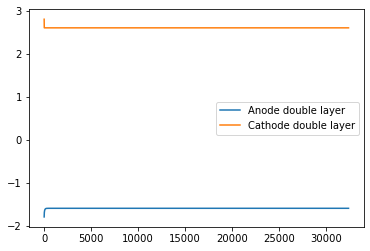

In [82]:
from matplotlib import pyplot as plt
for var in solution.y:
    plt.plot(solution.t,var)
    
plt.legend(['Anode double layer','Cathode double layer'])

For now, the battery double layer potentials simply go to those values needed to sustain the current density.